<a href="https://colab.research.google.com/github/angelo-kevin/tensorflow-intro/blob/master/intro_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics

tf.keras.backend.set_floatx('float64')
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
class GeneralModel(object):
    def __init__(self, df):
        self.model = None
        self.train_df = None
        self.features = []
        self.target = None
        
    def _build(self, features, target_var):
        self.features = self.train_df[features]
        self.target = self.train_df[target_var]
            

In [0]:
class LinearRegressor(GeneralModel):
    def __init__(self, df):
        super().__init__(df)
        self.train_df = df
    
    def build(self, features, target_var, learning_rate):
        super()._build(features, target_var)
        optimizer = tf.keras.optimizers.SGD(
            lr=learning_rate, 
            clipvalue = 5.0
        )
        
        feature_columns = []
        for f in features:
            feature_columns.append(tf.feature_column.numeric_column(f))
            
        self.model = tf.estimator.LinearRegressor(
            feature_columns = feature_columns,
            optimizer = optimizer
        )

    def input_fn(self, batch_size=1, shuffle=True, num_epochs=None):
        # Convert pandas data into a dict of np arrays.
        features = {key:np.array(value) for key,value in dict(self.features).items()}                                           

        # Construct a dataset, and configure batching/repeating.
        ds = tf.compat.v1.data.Dataset.from_tensor_slices((features, self.target)) 
        ds = ds.batch(batch_size).repeat(num_epochs)

        # Shuffle the data, if specified.
        if shuffle:
            ds = ds.shuffle(buffer_size=10000)

        # Return the next batch of data.
        features, labels = ds.make_one_shot_iterator().get_next()
        
        return features, labels

    def analyze_result(self, pred):
        print('\n======= RESULT ANALYSIS =======\n')
        
        # Print Mean Squared Error and Root Mean Squared Error.
        mean_squared_error = metrics.mean_squared_error(pred, self.target)
        root_mean_squared_error = math.sqrt(mean_squared_error)
        print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
        print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

        min_house_value = self.target.min()
        max_house_value = self.target.max()
        min_max_difference = max_house_value - min_house_value

        print("Min. Target Value: %0.3f" % min_house_value)
        print("Max. Target Value: %0.3f" % max_house_value)
        print("Difference between Min. and Max.: %0.3f" % min_max_difference)
        print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

        calibration_data = pd.DataFrame()
        calibration_data["predictions"] = pd.Series(pred)
        calibration_data["targets"] = pd.Series(self.target)
        print(calibration_data.describe())
        print('\n=============================\n')        

    def train(self, steps, *fn):
        training_input_fn, prediction_input_fn = fn
        self.model.train(input_fn = training_input_fn, steps = steps)

        pred = self.model.predict(input_fn = prediction_input_fn)
        return np.array([item['predictions'][0] for item in pred])


    def run_model(self, steps, batch_size, epochs):
        tr_fn = lambda:self.input_fn(batch_size=batch_size)
        pr_fn = lambda:self.input_fn(num_epochs=epochs, shuffle=False)

        predictions = self.train(steps, tr_fn, pr_fn)
        self.analyze_result(predictions)
        return predictions


In [0]:
from matplotlib import pyplot as plt

def plot_regression(df, x, y, model):
    if type(model).__name__ == "LinearRegressorV2":
        feat = x.replace(' ', '_')
        pos = 'linear/linear_model/'
        weight = model.get_variable_value(pos + feat + '/weights')[0]
        bias = model.get_variable_value(pos + 'bias_weights')
    else:
        weight = model.get_weights()[0][0]
        bias = model.get_weights()[1][0]
    sample = df.sample(n=500, replace = True)
    x_0 = sample[x].min()
    x_1 = sample[x].max()

    y_0 = weight * x_0 + bias 
    y_1 = weight * x_1 + bias

    plt.plot([x_0, x_1], [y_0, y_1], c='r')
    plt.ylabel(y)
    plt.xlabel(x)
    plt.scatter(sample[x], sample[y])
    plt.show()

In [0]:
def main(df, features, target, learning_rate = 0.01, steps_num = 100, 
         batch_size = 50, epochs_num = 1, plot = False):

    model = LinearRegressor(df)
        
    model.build(
        features = features, 
        target_var = target, 
        learning_rate = learning_rate
    )
    
    model.run_model(
        steps_num,
        batch_size = batch_size, 
        epochs = epochs_num,
    )

    if plot:
        plot_regression(df, features[0], target, model.model)


======= RESULT ANALYSIS =======

Mean Squared Error (on training data): 0.008
Root Mean Squared Error (on training data): 0.090
Min. Target Value: 0.000
Max. Target Value: 0.453
Difference between Min. and Max.: 0.453
Root Mean Squared Error: 0.090
       predictions     targets
count   156.000000  156.000000
mean      0.114191    0.110603
std       0.026043    0.094538
min       0.055020    0.000000
25%       0.094422    0.047000
50%       0.117776    0.085500
75%       0.135590    0.141250
max       0.165105    0.453000




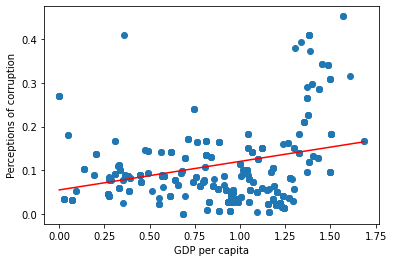

In [19]:
df = pd.read_csv("/content/2019.csv", sep=",")
df = df.reindex(
    np.random.permutation(df.index))

# Example
main(
    df = df, 
    features = ['GDP per capita'],
    target = 'Perceptions of corruption',
    learning_rate = 0.01, 
    steps_num = 500, 
    batch_size = 100, 
    epochs_num = 1, 
    plot = True
)